In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import itk
from matplotlib import pyplot as plt
import numpy as np
import pydicom
import sys
import cv2



In [2]:
def decompress_mamo_cases(directory):
    ics_filename = search_for_ics_filename(directory)
    if ics_filename == '':
        return []
    else:
        metadata = parse_ics_files(ics_filename)
    
    images = read_directory_contents(metadata, directory)
    
    return images


In [3]:
from os import listdir
from os.path import isfile, join
def search_for_ics_filename(directory):
  
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
    icsfiles  = [ (file) for file in onlyfiles if file.endswith(".ics")]
    return directory , icsfiles

In [4]:
import re

class image_file:
    def __init__(self,file_prefix, rows, columns, bpp, overl):
        self.file_prefix = file_prefix
        self.rows = rows
        self.columns = columns
        self.bpp = bpp
        self.overlay = overl
    
    def dump(self):
        return "File:" + self.file_prefix +"("+ str(self.rows) +"," + str(self.columns)+")"
            
class ics_struct:
    
    def __init__(self):
        self.files =[]
        
    def set_file(self,fil):        
        self.filename = fil
        
   
        
    def append_file(self,file_prefix, rows, columns, bpp, overl):
            f = image_file(file_prefix, rows, columns, bpp, overl)
            self.files.append(f)
        
    def set_patiend_age(self,age):
        self.patient_age = age
        
        
def parse_ics_files( dir_files_tuple):
    directory = dir_files_tuple[0]
    ics_files = dir_files_tuple[1]
    entries=[]
    for file in ics_files:   
        lines=[]
        with open(directory + "/" +file) as f:
            content = f.readlines()
            # you may also want to remove whitespace characters like `\n` at the end of each line
            content = [x.strip() for x in content] 
            if content != '':
                lines.append(content)
                
        #now we have the lines of a ics files
        #time to parse it
        #skip the first line   
        
        filename_regex = 'filename\s(.+)'
        patient_age_regex = 'PATIENT_AGE\s(\d+)'
        image_file_regex = '(\w+)\sLINES\s(\d+)\sPIXELS_PER_LINE\s(\d+)\sBITS_PER_PIXEL\s(\d+)\sRESOLUTION\s(\d+)\s(NON_OVERLAY|OVERLAY)'
        
        filename_prog = re.compile(filename_regex)
        patient_age_prog = re.compile(patient_age_regex)
        image_file_prog = re.compile(image_file_regex)
        
        ics = ics_struct()
        
        #the other type of lines are  irrelevant as of now...
        for line in lines[0]:
            #print(line)
            result = re.search(filename_regex,str(line))
            if result :
                #print("FOUND FILENAME:" + result.group(1))
                ics.set_file(result.group(1))
            else:
                result = re.match(patient_age_prog,str(line)) 
                if result :
                    #print("FOUND AGE:"+ result.group(1))
                    ics.set_patiend_age(int(result.group(1)))
                else:
                    result = re.match(image_file_prog,str(line) )
                    if result :
                        #print("FOUND FILE:"+ result.group(1))
                        ics.append_file(result.group(1), int(result.group(2)),int(result.group(3)), int(result.group(4)),result.group(5)=='OVERLAY')
        entries.append(ics)
        return entries
        #all lines done

In [5]:
ff = parse_ics_files(search_for_ics_filename('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001'))


In [6]:
import subprocess
import os
import shutil
def unpack_file(directory,filename,path_to_jpeg_tool,target_dir):    
    #print(path_to_jpeg_tool +" "+ directory+"/"+ filename)    
    process = subprocess.Popen(path_to_jpeg_tool + " " + directory+"/"+ filename, shell=True, stdout=subprocess.PIPE)    
    process.wait()        
    expected_output = directory+ "/" + filename +".1"
    target_output = target_dir+"/"+filename+".raw"
    print("Trying to move " + expected_output + " to " + target_output)
    shutil.move(expected_output, target_output)    
    return target_dir+"/"+filename+".raw"

In [7]:


ret = unpack_file('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001','C_0001_1.RIGHT_MLO.LJPEG',
            '/home/tiago/workspace/notebooks/execute_jpeg', '/tmp/tmp2')

Trying to move /home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001/C_0001_1.RIGHT_MLO.LJPEG.1 to /tmp/tmp2/C_0001_1.RIGHT_MLO.LJPEG.raw


In [8]:
def offset_img(img):
    mi = np.min(img)
    upimg = img.astype(np.uint16)
    tmp = [x - mi for x in upimg]
    return np.array(tmp).reshape(img.shape)
    

def window_it(img,center,width):
    imax = np.max(img)
    imin = np.min(img)
    ws = center - width//2
    we = center + width//2
    wd = we-ws
    factor = 255.0/wd
    
    nov = np.array([ (x - ws) * factor for x in np.clip(img,ws,we)]).astype(np.uint16)
    return nov.reshape(img.shape)


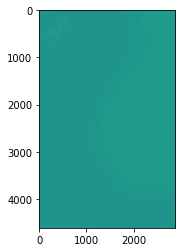

In [9]:
np.fromfile(ret)
A = np.fromfile(ret, dtype='>i2', sep="")
A = A.reshape(4616,2888)
plt.imshow(A)
plt.show()

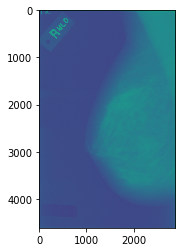

In [10]:
teste = window_it(A,3323,9374)
plt.imshow(teste)
plt.show()


In [11]:

#From here onwards A shall be the RAW image and we will try to improve it
raw_image = A

In [16]:
from scipy import ndimage


In [17]:
l2 = ndimage.median_filter(raw_image,2)


In [18]:
from skimage import data
from skimage import filters
from skimage import exposure

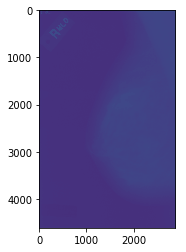

In [19]:
plt.imshow(l2)
plt.show()

In [20]:
l3 = l2*10

In [21]:
val = filters.threshold_otsu(l3)

In [22]:
l4 = l3 > val

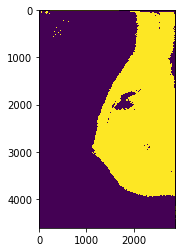

In [23]:
plt.imshow(l4)

In [24]:
 filled_mask = ndimage.binary_fill_holes(l4).astype(int)

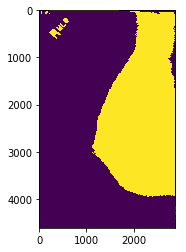

In [25]:
plt.imshow(filled_mask)

AttributeError: module 'scipy.ndimage' has no attribute 'labels'

1

In [26]:
import cv2

In [27]:
def largest_objects (image):    
    erosion_kernel = np.ones((3,3), np.uint16)
    dilated_image = cv2.erode(image.astype(np.uint8), erosion_kernel)
    #plt.imshow(dilated_image)
    #plt.show()
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(dilated_image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

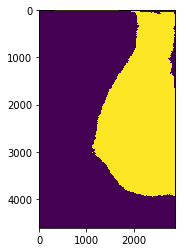

In [31]:
largest_object_mask = largest_objects(filled_mask)
plt.imshow(largest_object_mask)

In [32]:
#masked_mamo = np.zeros(l2.shape)
#masked_mamo[largest_object_mask]

IndexError: arrays used as indices must be of integer (or boolean) type

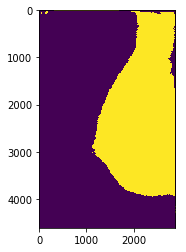

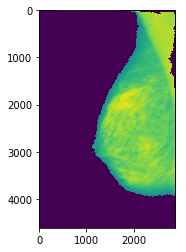

In [33]:
result = l2.copy()
result[largest_object_mask == 0] = (0)
plt.imshow(result)

In [34]:
#equalized_result  = cv2.equalizeHist(result.astype(np.uint16))
#plt.imshow(equalized_result)
#nao gostei

from skimage import exposure

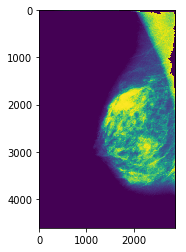

In [35]:
img_eq = exposure.equalize_hist(result)
plt.imshow(img_eq)

In [126]:
# now to remove the muscle

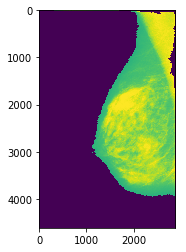

In [36]:
cut_again = img_eq.copy()
cut_again[largest_object_mask == 0] = (0)
plt.imshow(cut_again)

In [131]:
#find the smallest and largest columns and rows that are not empty
col_ind = np.nonzero(cut_again.any(axis=0))[0] # indices of non empty columns 
width = col_ind[-1] - col_ind[0] + 1
row_ind = np.nonzero(cut_again.any(axis=1))[0] # indices of non empty rows
height = row_ind[-1] - row_ind[0] + 1

print(width)
print(height)
print(row_ind)
print(col_ind)

2688
4098
[   0    1    2 ... 4095 4096 4097]
[ 181  182  183 ... 2866 2867 2868]


In [132]:
bounding_box = [(row_ind[0], row_ind[-1]),(col_ind[0], col_ind[-1])]

In [125]:
img_eq.shape

(4616, 2888)